# コード3-1：ギレスピーアルゴリズムによる確率シミュレーションの実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

ギレスピーアルゴリズムによる確率シミュレーションの実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [1]:
## 必要があればインストール
# !pip3 install matplotlib numpy gillespy2 time

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gillespy2
import time ## 実行時間測定

## ギレスピーアルゴリズム


式(3.6)

$$
\frac{d V_{\text{det}}(t)}{dt} = k_{\text{det}} V_{\text{att}}(t) - k_{\text{att}} V_{\text{det}}(t) \\
\frac{d V_{\text{att}}(t)}{dt} = k_{\text{att}} V_{\text{det}}(t) - k_{\text{det}} V_{\text{att}}(t) - k_{\text{int}} V_{\text{att}}(t) \\
\frac{d V_{\text{int}}(t)}{dt} = k_{\text{int}} V_{\text{att}}(t) - k_{\text{ccc}} \left( 1 - \frac{V_{\text{ccc}}(t)}{K} \right) V_{\text{int}}(t) - k_{\text{di}} V_{\text{int}}(t) \\
\frac{d V_{\text{ccc}}(t)}{dt} = k_{\text{ccc}} \left( 1 - \frac{V_{\text{ccc}}(t)}{K} \right) V_{\text{int}}(t) - k_{\text{dc}} V_{\text{ccc}}(t)
$$

で表されるHBVの侵入動態についてギレスピーアルゴリズムを用いた確率シミュレーションを行う。

ここで、表(3.2)から$k_{\text{det}} = 3.38, k_{\text{att}} = 0.16, k_{\text{int}} = 3.07, k_{\text{ccc}} = 0.65, k_{\text{di}} = 1.94, k_{\text{dc}} = 0.12, K = 3.73$である。

HBVの侵入動態の確率シミュレーションで更新される系は、4つの変数

$$V_{\text{det}}(t), V_{\text{att}}(t), V_{\text{int}}(t), V_{\text{ccc}}(t)$$

と、モデルで定義される７つの反応

$$
\begin{cases}
E_1(t) = k_{\text{det}} V_{\text{att}}(t) \\
E_2(t) = k_{\text{att}} V_{\text{det}}(t) \\
E_3(t) = k_{\text{int}} V_{\text{att}}(t) \\
E_4(t) = k_{\text{ccc}} V_{\text{int}}(t) \\
E_5(t) = \frac{k_{\text{ccc}} V_{\text{ccc}}(t) V_{\text{int}}(t)}{K} \\
E_6(t) = k_{\text{di}} V_{\text{int}}(t) \\
E_7(t) = k_{\text{dc}} V_{\text{ccc}}(t)
\end{cases}
$$

で構成される。

Pythonでのギレスピーアルゴリズムの実装は多く存在する。ここでは、`GillesPy2`を用いた。  
リポジトリ：https://github.com/StochSS/GillesPy2  
ドキュメンテーション：https://stochss.github.io/GillesPy2/docs/build/html/index.html

In [58]:
## パラメータ
## k_det, k_att, k_int, k_ccc, k_di, k_dc, K
pars = [3.38, 0.16, 3.07, 0.65, 1.94, 0.12, 3.73]

### 直接法

In [81]:
## モデルの定義
def create_HBV(parameter_values=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]):
    # モデルの初期化
    model = gillespy2.Model(name='HBV')

    # パラメータの定義
    k_det = gillespy2.Parameter(name='k_det', expression=parameter_values[0])
    k_att = gillespy2.Parameter(name='k_att', expression=parameter_values[1])
    k_int = gillespy2.Parameter(name='k_int', expression=parameter_values[2])
    k_ccc = gillespy2.Parameter(name='k_ccc', expression=parameter_values[3])
    k_di = gillespy2.Parameter(name='k_di', expression=parameter_values[4])
    k_dc = gillespy2.Parameter(name='k_dc', expression=parameter_values[5])
    K = gillespy2.Parameter(name='K', expression=parameter_values[6])
    model.add_parameter([k_det, k_att, k_int, k_ccc, k_di, k_dc, K])

    # 変数の定義
    V_det = gillespy2.Species(name='V_det', initial_value=1)
    V_att = gillespy2.Species(name='V_att', initial_value=130)
    V_int = gillespy2.Species(name='V_int', initial_value=1)
    V_ccc = gillespy2.Species(name='V_ccc', initial_value=1)
    model.add_species([V_det, V_att, V_int, V_ccc])

    # 反応の定義
    E_1 = gillespy2.Reaction(name="E_1", rate=k_det, reactants={V_att:1}, products={V_det:1})
    E_2 = gillespy2.Reaction(name="E_2", rate=k_att, reactants={V_det:1}, products={V_att:1})
    E_3 = gillespy2.Reaction(name="E_3", rate=k_int, reactants={V_att:1}, products={V_int:1})
    E_4 = gillespy2.Reaction(name="E_4", rate=k_ccc, reactants={V_int:1}, products={V_ccc:1})
    ## rateの代わりにpropensity_functionとして反応自体を記述することも可能
    E_5 = gillespy2.Reaction(name="E_5", propensity_function="k_ccc*V_ccc*V_int/K", reactants={V_ccc:1}, products={V_int:1})
    E_6 = gillespy2.Reaction(name="E_6", rate=k_di, reactants={V_int:1}, products={})
    E_7 = gillespy2.Reaction(name="E_7", rate=k_dc, reactants={V_ccc:1}, products={})
    model.add_reaction([E_1, E_2, E_3, E_4, E_5, E_6, E_7])

    # Set the timespan for the simulation.
    tspan = gillespy2.TimeSpan.linspace(t=70/24, num_points=100001)
    model.timespan(tspan)
    return model

In [82]:
time_start = time.time() 

## 10回のシミュレーション
model_HBV = create_HBV(pars)
results_HBV = model_HBV.run(number_of_trajectories=10, debug=True, algorithm = "SSA")

time_end = time.time()
time_gillespiessa = time_end - time_start
print(f"経過時間：{time_gillespiessa}")

経過時間：3.392224073410034


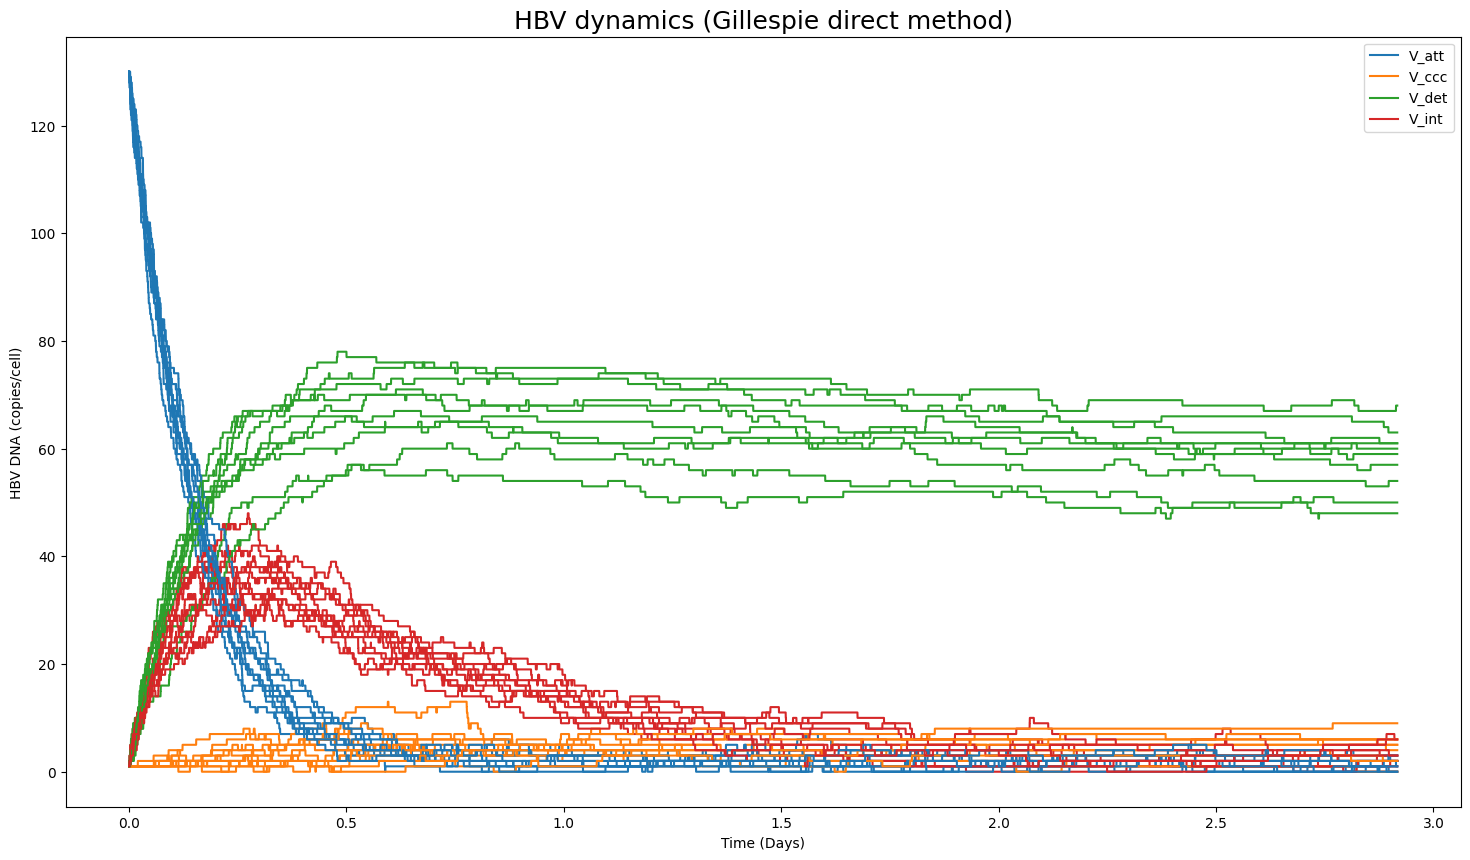

In [83]:
results_HBV.plot(xaxis_label="Time (Days)",
                 yaxis_label="HBV DNA (copies/cell)",
                 title="HBV dynamics (Gillespie direct method)")

In [73]:
## ODEの数値解
d_results_HBV = model_HBV.run(algorithm="ODE")

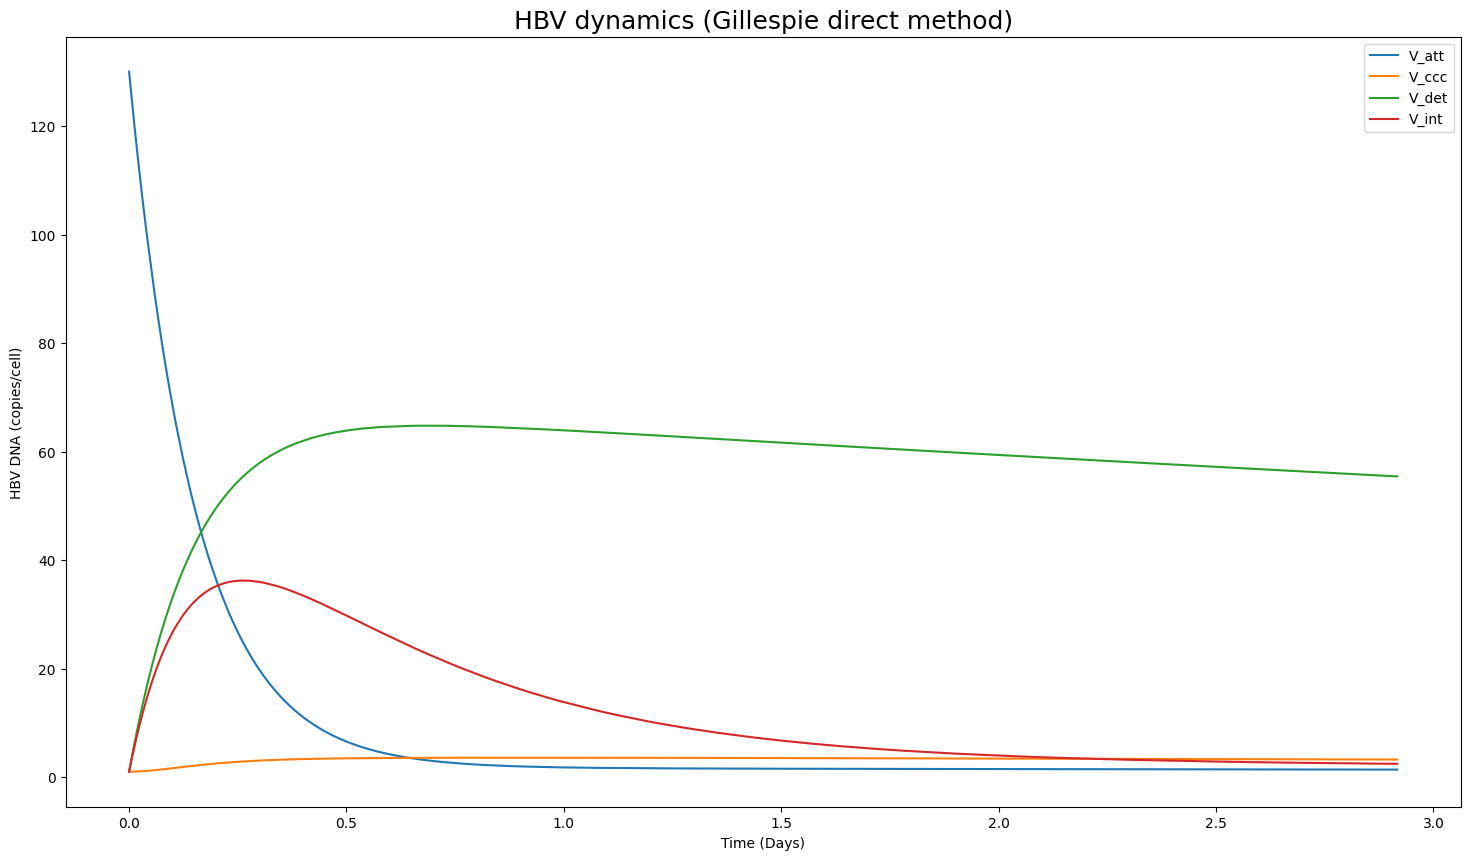

In [74]:
d_results_HBV.plot(xaxis_label="Time (Days)",
                   yaxis_label="HBV DNA (copies/cell)",
                   title="HBV dynamics (Gillespie direct method)")

### tau-leap法

In [84]:
time_start = time.time() 

## 10回のシミュレーション
model_HBV = create_HBV(pars)
results_HBV_tauleaping = model_HBV.run(number_of_trajectories=10, debug=True, algorithm="Tau-Leaping")

time_end = time.time()
time_gillespietauleaping = time_end - time_start
print(f"経過時間：{time_gillespietauleaping}")

経過時間：19.744652271270752


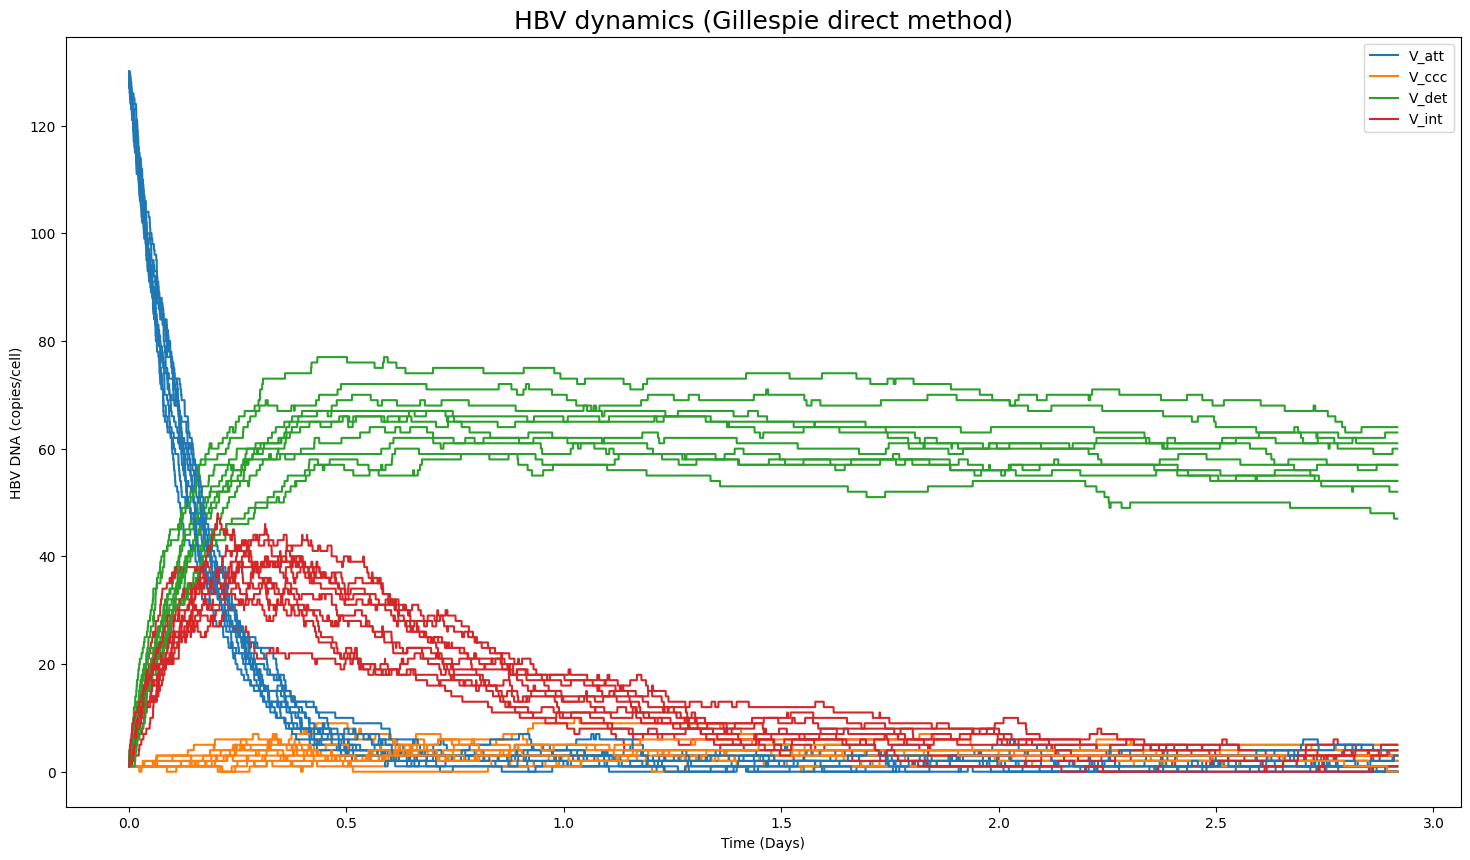

In [85]:
results_HBV_tauleaping.plot(xaxis_label="Time (Days)",
                            yaxis_label="HBV DNA (copies/cell)",
                            title="HBV dynamics (Gillespie direct method)")

### tau-hybrid

In [86]:
time_start = time.time() 

## 10回のシミュレーション
model_HBV = create_HBV(pars)
results_HBV_tauhybrid = model_HBV.run(number_of_trajectories=10, debug=True, algorithm="Tau-Hybrid")

time_end = time.time()
time_gillespietauhybrid = time_end - time_start
print(f"経過時間：{time_gillespietauhybrid}")

経過時間：32.45031237602234


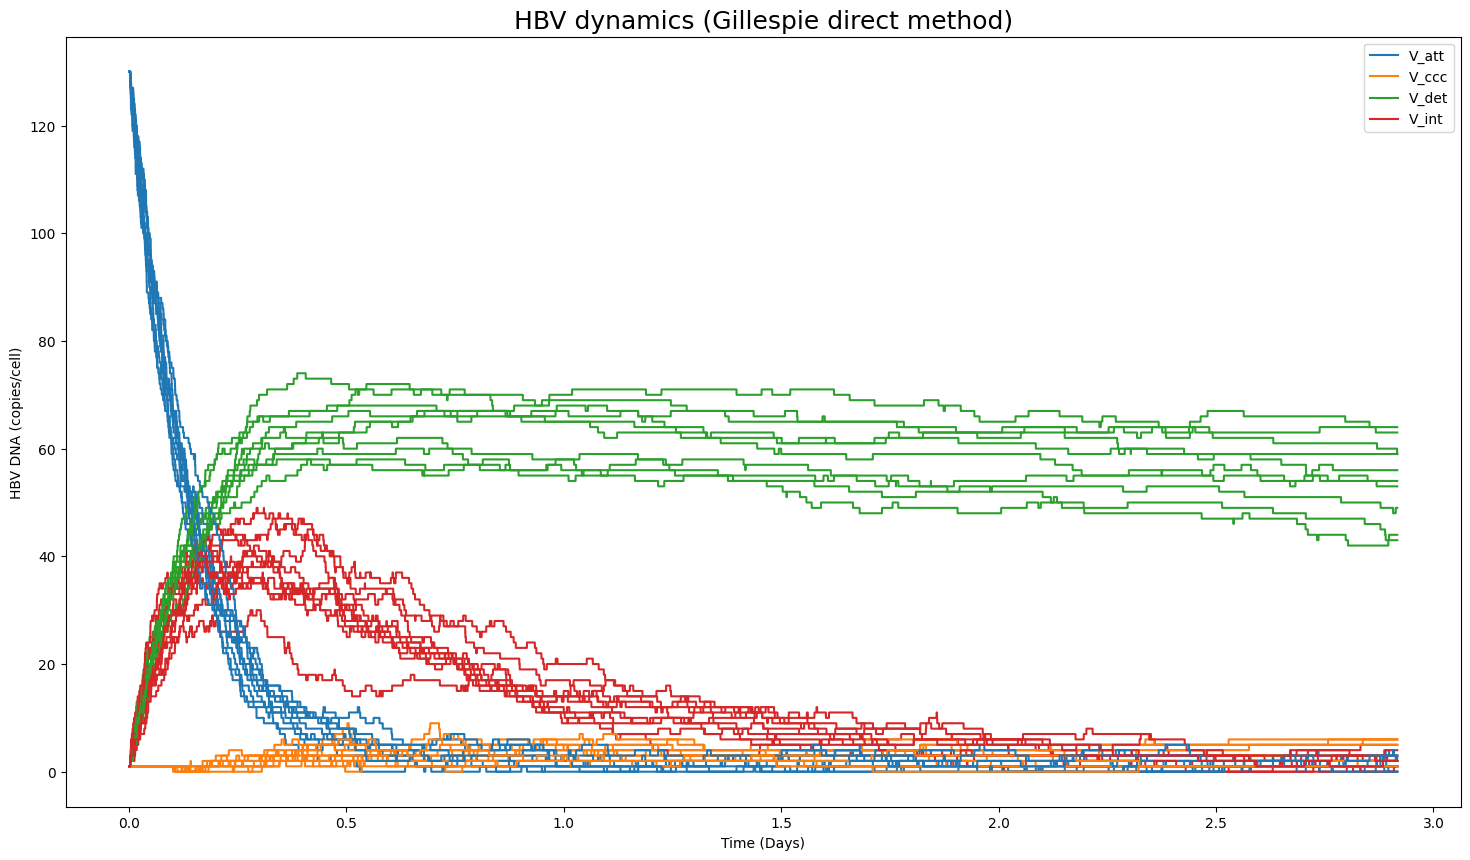

In [87]:
results_HBV_tauhybrid.plot(xaxis_label="Time (Days)",
                           yaxis_label="HBV DNA (copies/cell)",
                           title="HBV dynamics (Gillespie direct method)")

In [88]:
## 計算時間の比較
## 絶対数が少ない計算では直接法が一番早いようだ（計算時間は個体数に依存するので、個体数が多い状況ではtau leap法などが早い）
print(f"直接法：{time_gillespiessa}\ntau-leap法：{time_gillespietauleaping}\ntau-hybrid法：{time_gillespietauhybrid}")

直接法：3.392224073410034
tau-leap法：19.744652271270752
tau-hybrid法：32.45031237602234


### GillesPy2のサンプルコード

https://github.com/StochSS/GillesPy2#simple-example-to-illustrate-the-use-of-gillespy2

In [182]:
## from https://github.com/StochSS/GillesPy2#simple-example-to-illustrate-the-use-of-gillespy2

def create_dimerization(parameter_values=None):
    # First call the gillespy2.Model initializer.
    model = gillespy2.Model(name='Dimerization')

    # Define parameters for the rates of creation and dissociation.
    k_c = gillespy2.Parameter(name='k_c', expression=0.005)
    k_d = gillespy2.Parameter(name='k_d', expression=0.08)
    model.add_parameter([k_c, k_d])

    # Define variables for the molecular species representing M and D.
    m = gillespy2.Species(name='monomer', initial_value=30)
    d = gillespy2.Species(name='dimer',   initial_value=0)
    model.add_species([m, d])

    # The list of reactants and products for a Reaction object are each a
    # Python dictionary in which the dictionary keys are Species objects
    # and the values are stoichiometries of the species in the reaction.
    r_c = gillespy2.Reaction(name="r_creation", rate=k_c, reactants={m:2}, products={d:1})
    r_d = gillespy2.Reaction(name="r_dissociation", rate=k_d, reactants={d:1}, products={m:2})
    model.add_reaction([r_c, r_d])

    # Set the timespan for the simulation.
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    model.timespan(tspan)
    return model

In [183]:
## from https://github.com/StochSS/GillesPy2#simple-example-to-illustrate-the-use-of-gillespy2

model = create_dimerization()
results = model.run(number_of_trajectories=10)

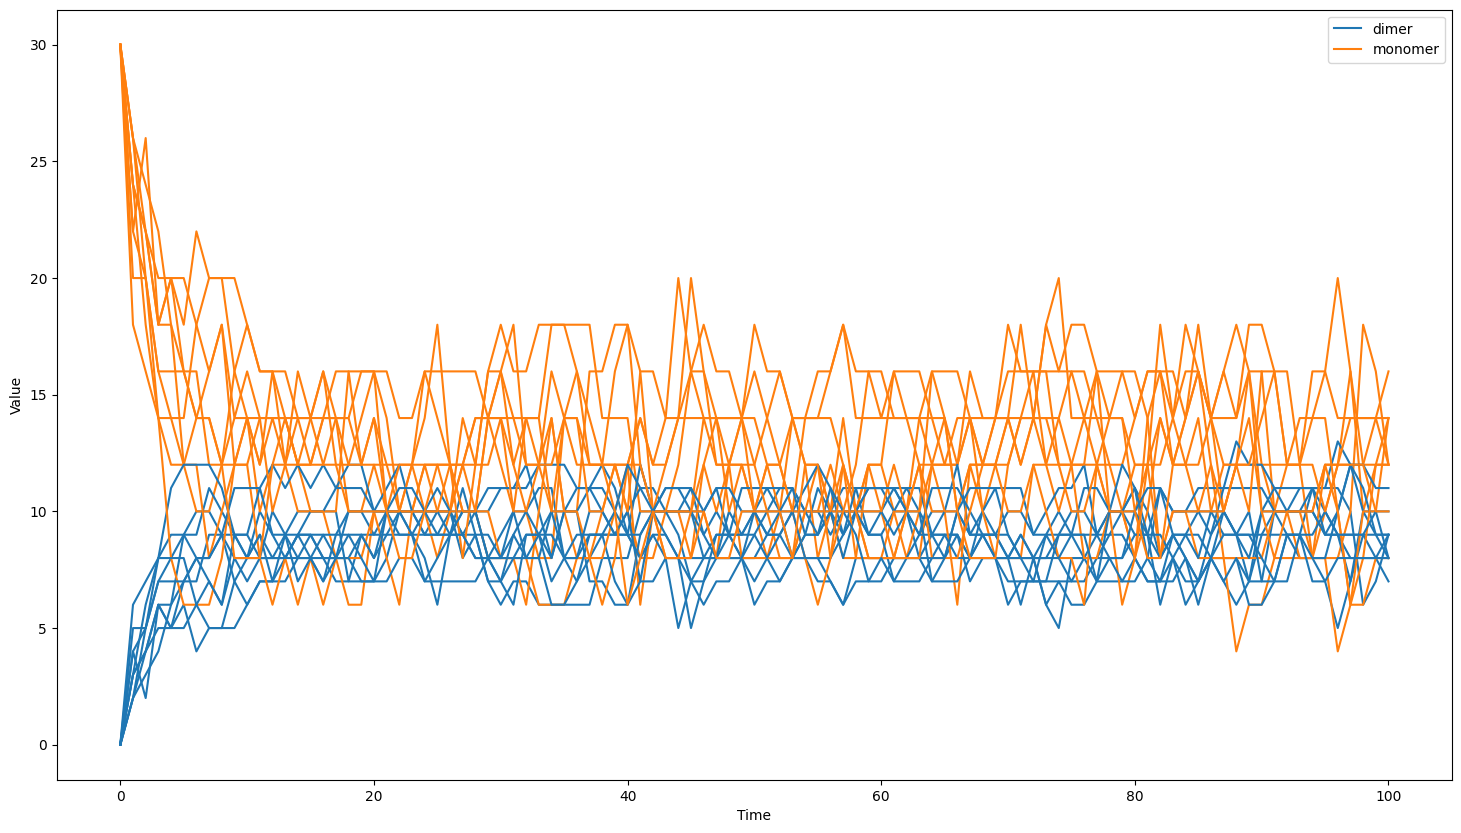

In [184]:
## from https://github.com/StochSS/GillesPy2#simple-example-to-illustrate-the-use-of-gillespy2

results.plot()

In [185]:
## 最初のrunの結果
print("Time")
print(results[0]["time"])

print("Dimer")
print(results[0]["dimer"])

print("Monomer")
print(results[0]["monomer"])

Time
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]
Dimer
[ 0.  2.  4.  6.  5.  7.  7.  9.  9.  7.  6.  7.  7.  7.  8.  9.  8.  7.
  7.  7.  7.  8. 10.  9. 10. 10. 10.  9.  9.  7.  6.  7.  7.  6.  6.  6.
  6.  6.  8.  8.  8. 10. 10. 10. 10. 11.  9. 10.  9.  9. 10. 11. 10.  8.
  8.  8.  7.  6.  7.  7.  7.  8.  8.  8.  9.  9.  9.  7.  8.  8.  7.  7.
  7.  7.  7.  7.  7.  8.  9. 10. 11. 10.  8.  9.  8.  7.  8.  8.  8.  7.
  9.  9.  9.  8.  8.  7.  5.  7. 10.  9.  9.]
Monomer
[30. 26. 22. 18. 20. 16. 16. 12. 12. 16. 18. 16. 16. 16.

In [186]:
## runの数
len(results)

10

In [187]:
results

Results([{'time': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
                 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
                 22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
                 33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
                 44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
                 55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
                 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
                 77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
                 88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
                 99., 100.]), 'dimer': array([ 0.,  2.,  4.,  6.,  5.,  7.,  7.,  9.,  9.,  7.,  6.,  7.,  7.,
                 7.,  8.,  9.,  8.,  7.,  7.,  7.,  7.,  8., 10.,  9., 10., 10.,
                10.,  9.,  9.,  7.,  6.,  7.,  7.,  6.,  6., 